In [24]:
using CSV, DataFrames, Statistics, Dates
using JuMP, HiGHS


In [25]:
# Synthetic 30-day sample for 1 store, 1 item
df = DataFrame(
    date  = Date.(2024,1,1) .+ Day.(0:29),
    store = repeat([1], 30),
    item  = repeat([1], 30),
    sales = rand(10:30, 30),
)

first(df, 5)


Row,date,store,item,sales
,Date,Int64,Int64,Int64
1,2024-01-01,1,1,23
2,2024-01-02,1,1,26
3,2024-01-03,1,1,10
4,2024-01-04,1,1,29
5,2024-01-05,1,1,10


In [26]:
"""
    moving_average_forecast(values, window)

Return the mean of the last `window` observations.
"""
function moving_average_forecast(values, window)
    if length(values) < window
        return mean(values)
    else
        return mean(values[end-window+1:end])
    end
end

forecast = moving_average_forecast(df.sales, 7)
println("Forecasted demand = ", forecast)


Forecasted demand = 21.714285714285715


In [27]:
holding_cost  = 2
stockout_cost = 5.0

model = Model(HiGHS.Optimizer)

@variable(model, q >= 0)
@variable(model, s >= 0)

@constraint(model, s >= forecast - q)

@objective(model, Min, holding_cost*q + stockout_cost*s)

optimize!(model)

optimal_q = value(q)
println("Optimal order quantity = ", optimal_q)
println("Expected stockout = ", value(s))

Running HiGHS 1.12.0 (git hash: 755a8e027): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 1 row; 2 cols; 2 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [2e+00, 5e+00]
  Bound   [0e+00, 0e+00]
  RHS     [2e+01, 2e+01]
Presolving model
1 rows, 1 cols, 1 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-1); columns 0(-2); nonzeros 0(-2) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

Model status        : Optimal
Objective value     :  4.3428571429e+01
P-D objective error :  0.0000000000e+00
HiGHS run time      :          0.00
Optimal order quantity = 21.714285714285715
Expected stockout = 0.0


In [28]:
inventory = 0.0
results = DataFrame()

for t in 8:30
    # -----------------------
    # 1. Forecast using history
    # -----------------------
    f = moving_average_forecast(df.sales[1:t-1], 7)

    # -----------------------
    # 2. Optimization model
    # -----------------------
    model = Model(HiGHS.Optimizer)
    @variable(model, q >= 0)
    @variable(model, s >= 0)
    @constraint(model, s >= f - q)
    @objective(model, Min, holding_cost*q + stockout_cost*s)
    optimize!(model)

    q_opt = value(q)

    # -----------------------
    # 3. Apply order & simulate
    # -----------------------
    demand = df.sales[t]

    inventory += q_opt
    sales     = min(inventory, demand)
    inventory -= sales

    # -----------------------
    # 4. Store results
    # -----------------------
    push!(results, (
        day            = t,
        forecast       = f,
        order_qty      = q_opt,
        demand         = demand,
        ending_inventory = inventory
    ))
end

results


Running HiGHS 1.12.0 (git hash: 755a8e027): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 1 row; 2 cols; 2 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [2e+00, 5e+00]
  Bound   [0e+00, 0e+00]
  RHS     [2e+01, 2e+01]
Presolving model
1 rows, 1 cols, 1 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-1); columns 0(-2); nonzeros 0(-2) - Reduced to empty
Performed postsolve
Solving the original LP from the solution after postsolve

Model status        : Optimal
Objective value     :  3.9428571429e+01
P-D objective error :  0.0000000000e+00
HiGHS run time      :          0.00
Running HiGHS 1.12.0 (git hash: 755a8e027): Copyright (c) 2025 HiGHS under MIT licence terms
LP has 1 row; 2 cols; 2 nonzeros
Coefficient ranges:
  Matrix  [1e+00, 1e+00]
  Cost    [2e+00, 5e+00]
  Bound   [0e+00, 0e+00]
  RHS     [2e+01, 2e+01]
Presolving model
1 rows, 1 cols, 1 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve reductions: rows 0(-1); columns 0(

Row,day,forecast,order_qty,demand,ending_inventory
,Int64,Float64,Float64,Int64,Float64
1,8,19.7143,19.7143,20,0.0
2,9,19.2857,19.2857,30,0.0
3,10,19.8571,19.8571,12,7.85714
4,11,20.1429,20.1429,18,10.0
5,12,18.5714,18.5714,22,6.57143
6,13,20.2857,20.2857,19,7.85714
7,14,19.2857,19.2857,28,0.0
8,15,21.2857,21.2857,17,4.28571
9,16,20.8571,20.8571,12,13.1429


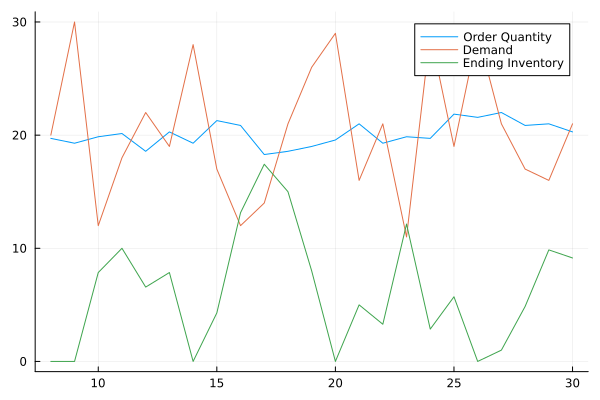

In [29]:
using Plots

plot(results.day, results.order_qty, label="Order Quantity")
plot!(results.day, results.demand, label="Demand")
plot!(results.day, results.ending_inventory, label="Ending Inventory")
